<a href="https://colab.research.google.com/github/yuvarshini/Bigdataproject/blob/main/Sentiment_classification_using_LSTM%2CBERT_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from xgboost import XGBClassifier

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.1 MB/s 
     |████████████████████████████████| 182 kB 34.4 MB/s 
     |████████████████████████████████| 7.6 MB 37.1 MB/s 


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import string
import joblib

from warnings import filterwarnings
filterwarnings("ignore")

import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import collections
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

import transformers
from transformers import BertTokenizer, TFBertModel


In [ ]:
def preprocessor(text):
    # convert to lowercase, susbstitute non alphanumerical characters with whitespaces
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [ ]:
def test_performance(model, X_test):
    ''' Given a fitted model and a test set, returns optimal hyperparameters, AUC and accuracy '''
    clf_b = model.best_estimator_
    y_pred_proba = clf_b.predict_proba(X_test)
    y_pred = clf_b.predict(X_test)

    # performance metrics
    auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])
    acc = accuracy_score(y_test, y_pred)

    return (model.best_params_, auc_res, acc)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = list(set(stopwords.words("english")))

In [ ]:
train_data=pd.read_csv("Corona_NLP_test.csv")
test_data=pd.read_csv("Corona_NLP_test.csv")

In [ ]:
# merge train and test datasets
df = pd.concat([train_data, test_data], axis = 0)
df.shape

(7596, 6)

In [ ]:
# duplicated tweets
duplicates = df[df.duplicated()]
len(duplicates)

3798

In [ ]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         1668
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


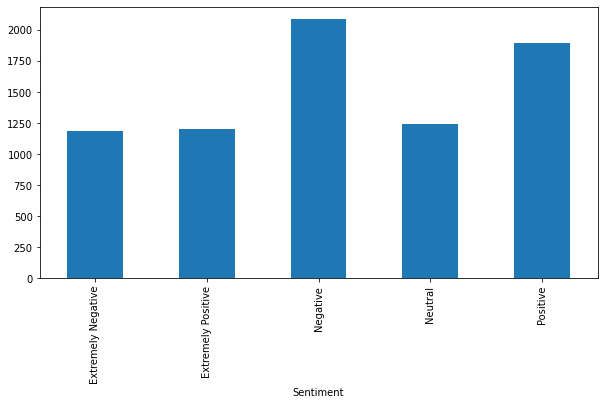

In [ ]:
counts = df.groupby("Sentiment")["Sentiment"].agg("count")

fig, ax = plt.subplots(figsize=(10,5))
counts.plot.bar()

In [ ]:
# remove neutral tweets
df.drop(df[df.Sentiment == "Neutral"].index, inplace = True)

df.Sentiment.unique()

array(['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative'],
      dtype=object)

In [ ]:
# Aggregate extremely positive/negative values
df = df.replace("Extremely Positive", "Positive")
df = df.replace("Extremely Negative", "Negative")

df.Sentiment.unique()

array(['Negative', 'Positive'], dtype=object)

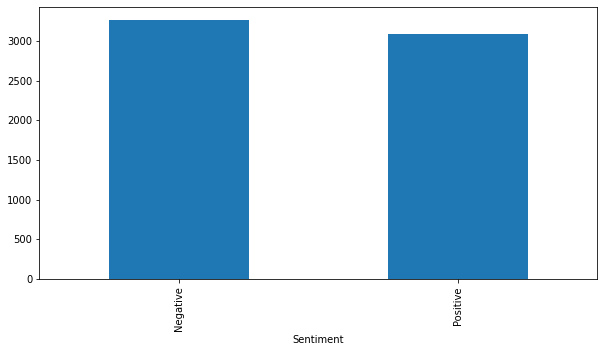

In [ ]:
counts = df.groupby("Sentiment")["Sentiment"].agg("count")
fig, ax = plt.subplots(figsize=(10,5))

counts.plot.bar()

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive


In [ ]:
# count number of words per headline. strip whitespaces at the beginning/end of the sentence
# and tokenize by whitespace
df_select = df[["OriginalTweet", "Sentiment"]]
df_select["word_count"] = df_select["OriginalTweet"].apply(lambda x: len(x.strip().split(" ")))
df_select.head()

,OriginalTweet,Sentiment,word_count
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31
2,Find out how you can protect yourself and love...,Positive,13
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35
6,Voting in the age of #coronavirus = hand sanit...,Positive,12


In [ ]:
# summary statistics of word counts
df_select["word_count"].describe()

count    6358.000000
mean       34.329663
std        10.979474
min         2.000000
25%        26.000000
50%        36.000000
75%        43.000000
max        71.000000
Name: word_count, dtype: float64

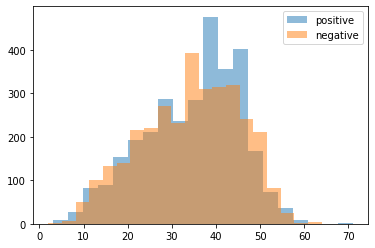

In [ ]:
# distributions of word counts by sentiment
pos = df_select[df_select.Sentiment == "Positive"].word_count
neg =  df_select[df_select.Sentiment == "Negative"].word_count

plt.hist(pos, bins = 20, alpha = 0.5, label='positive')
plt.hist(neg, bins = 20, alpha = 0.5, label='negative')
plt.legend(loc='upper right')
plt.show()

In [ ]:
df_select

,OriginalTweet,Sentiment,word_count
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31
2,Find out how you can protect yourself and love...,Positive,13
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35
6,Voting in the age of #coronavirus = hand sanit...,Positive,12
...,...,...,...
3792,"@RicePolitics @MDCounties Craig, will you call...",Negative,29
3793,Meanwhile In A Supermarket in Israel -- People...,Positive,18
3794,Did you panic buy a lot of non-perishable item...,Negative,34
3796,Gov need to do somethings instead of biar je r...,Negative,29


In [ ]:
# save dataset
df_select.to_csv("./binary_data.csv",index = False, encoding = "utf-8")

In [ ]:
df = pd.read_csv("./binary_data.csv")

In [ ]:
# select random tweet
text = df.OriginalTweet.iloc[400]
text

"Have been talking to lots of Trump supporters across the country these last couple of days, and the disdain for and distrust of the media right now is worse than I've seen at any point throughout this presidency."

In [ ]:
# preprocess entire corpus
df['tweet_clean'] = df['OriginalTweet'].apply(preprocessor)
df.head()

,OriginalTweet,Sentiment,word_count,tweet_clean
0,TRENDING: New Yorkers encounter empty supermar...,Negative,23,trending new yorkers encounter empty supermark...
1,When I couldn't find hand sanitizer at Fred Me...,Positive,31,when i couldn t find hand sanitizer at fred me...
2,Find out how you can protect yourself and love...,Positive,13,find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...,Negative,35,panic buying hits newyork city as anxious sho...
4,Voting in the age of #coronavirus = hand sanit...,Positive,12,voting in the age of coronavirus hand sanitize...


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# tokenize the dataset with nltk tokenizer
text_processed = df.tweet_clean.apply( word_tokenize )
text_processed

0       [trending, new, yorkers, encounter, empty, sup...
1       [when, i, couldn, t, find, hand, sanitizer, at...
2       [find, out, how, you, can, protect, yourself, ...
3       [panic, buying, hits, newyork, city, as, anxio...
4       [voting, in, the, age, of, coronavirus, hand, ...
                              ...                        
6353    [ricepolitics, mdcounties, craig, will, you, c...
6354    [meanwhile, in, a, supermarket, in, israel, pe...
6355    [did, you, panic, buy, a, lot, of, non, perish...
6356    [gov, need, to, do, somethings, instead, of, b...
6357    [i, and, forestandpaper, members, are, committ...
Name: tweet_clean, Length: 6358, dtype: object

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# POS-tags for the whole dataset
text_tagged = text_processed.apply(pos_tag)
text_tagged

0       [(trending, VBG), (new, JJ), (yorkers, NNS), (...
1       [(when, WRB), (i, NN), (couldn, VBP), (t, NN),...
2       [(find, VB), (out, RP), (how, WRB), (you, PRP)...
3       [(panic, JJ), (buying, NN), (hits, NNS), (newy...
4       [(voting, NN), (in, IN), (the, DT), (age, NN),...
                              ...                        
6353    [(ricepolitics, NNS), (mdcounties, NNS), (crai...
6354    [(meanwhile, RB), (in, IN), (a, DT), (supermar...
6355    [(did, VBD), (you, PRP), (panic, VB), (buy, VB...
6356    [(gov, NNS), (need, VBP), (to, TO), (do, VB), ...
6357    [(i, NN), (and, CC), (forestandpaper, JJ), (me...
Name: tweet_clean, Length: 6358, dtype: object

In [ ]:
def retrieve_tags(text):
    # form a string of tags from POS-tag text
    return "-".join(tag for (word, tag) in text)

df["text_pos"] = text_tagged.apply(retrieve_tags)
df.text_pos

0       VBG-JJ-NNS-VBP-JJ-NN-NNS-VBD-NNS-IN-NN-VBN-RP-...
1       WRB-NN-VBP-NN-VBP-NN-NN-IN-JJ-NN-NN-VBD-TO-VB-...
2                VB-RP-WRB-PRP-MD-VB-PRP-CC-VBD-NNS-IN-NN
3       JJ-NN-NNS-VBP-NN-IN-JJ-NNS-NN-RB-IN-NN-NN-JJ-N...
4                 NN-IN-DT-NN-IN-NN-NN-NN-NN-VBD-JJ-NN-NN
                              ...                        
6353    NNS-NNS-VBP-MD-PRP-VB-IN-DT-JJ-NN-TO-VB-DT-JJ-...
6354    RB-IN-DT-NN-IN-JJ-NNS-NN-CC-VBG-RB-TO-VB-JJ-NN...
6355    VBD-PRP-VB-VB-DT-NN-IN-NN-JJ-NNS-VBP-NNS-NN-NN...
6356    NNS-VBP-TO-VB-NNS-RB-IN-JJ-NN-NN-VBP-JJ-NN-CC-...
6357    NN-CC-JJ-NNS-VBP-VBN-TO-DT-NN-IN-PRP$-NNS-CC-P...
Name: text_pos, Length: 6358, dtype: object

In [ ]:
# load pre-trained word embedding model from spacy
!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')

2022-11-27 16:35:01.955368: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 301 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
# example on random tweet
print( nlp(text) )
print( )
print( nlp(text).vector[:20])


Have been talking to lots of Trump supporters across the country these last couple of days, and the disdain for and distrust of the media right now is worse than I've seen at any point throughout this presidency.

[-2.2430875   0.31259587 -2.511582    1.1530114   5.0358505   1.0344031
  0.76018673  5.1734204   0.21933225  0.474815    6.314838    2.230242
 -3.6703875   0.5104935   0.81468946  2.1584044   1.1790328  -1.8672558
 -1.9416398  -1.9658836 ]


In [ ]:
# stack embeddings of tweets
# each tweet has a 1x300 embedding
emb = np.vstack(df.tweet_clean.apply(lambda x: nlp(x).vector))
len(emb[0])

300

In [ ]:
# convert embeddings to dataframe
emb_df = pd.DataFrame(emb, columns = np.array([str(x) for x in range(0, len(emb[0]))]) )
print(emb_df.shape)
emb_df.head()

(6358, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.891958,0.325154,-2.062366,1.340930,2.533503,0.112686,0.823051,2.036370,-1.687886,-1.425946,...,-1.012633,-0.346946,-0.757741,-1.915718,-2.093584,0.114370,0.975655,-0.964466,-2.735620,0.557998
1,-1.256169,0.411010,-2.785302,-0.033508,2.118214,0.287657,0.180948,3.885340,-2.748641,-0.392724,...,-0.617714,-0.616937,0.969958,-1.447316,-1.959462,0.256157,0.727377,-0.551406,-4.059825,1.686138
2,0.879349,0.786262,-5.566750,-1.598292,1.157152,1.936206,-0.577861,2.262260,-3.088804,0.846556,...,0.875909,-2.219763,1.376182,-0.514811,-0.002999,-1.129727,-1.473948,-0.701530,-2.954793,0.404253
3,-0.733919,0.446307,-2.309876,0.746547,3.198810,-0.813633,0.090123,2.263667,-0.182622,-0.931874,...,-0.718542,0.067991,-1.103323,-1.350602,-2.022518,0.000083,1.174880,-0.757366,-2.303353,1.166352
4,-2.309330,0.901132,-0.473967,1.618246,4.785238,0.299894,1.590768,4.593878,-0.224665,-2.019306,...,-0.756345,0.794560,-1.324308,-1.672478,-2.025760,-0.285712,0.730550,-2.748705,-1.930582,-0.253589


In [ ]:
# add embeddings to dataset
df_embed = pd.concat([df, emb_df], axis = 1)
df = df_embed.drop(columns=["OriginalTweet",'word_count'])

In [ ]:
# convert sentiment label to real-valued target
le = LabelEncoder()
le.fit(df.Sentiment)

df['target_encoded'] = le.transform(df.Sentiment)
df.target_encoded

0       0
1       1
2       1
3       0
4       1
       ..
6353    0
6354    1
6355    0
6356    0
6357    1
Name: target_encoded, Length: 6358, dtype: int64

In [ ]:
# save dataset
df.to_csv("./preprocessed_data.csv",index = False, encoding = "utf-8")

In [ ]:
df_imp = pd.read_csv("./preprocessed_data.csv")
df_imp.shape

(6358, 304)

In [ ]:
# train the models on about 30% of the original data
df = df_imp.sample(frac = 0.3 )
df.shape

(1907, 304)

In [ ]:
# reshuffle data
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation

In [ ]:
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

1525 382


In [ ]:
# split dataset
df_train = df.head(train_size)
y_train = df.head(train_size).target_encoded

df_test = df.tail(test_size)
y_test = df.tail(test_size).target_encoded
# set tfidf and cross validation parameters for all models
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

cv = StratifiedKFold(n_splits=5,
                     shuffle=False)

In [ ]:
df = pd.read_csv("./binary_data.csv")
df.shape

(6358, 3)

In [ ]:
# reshuffle data
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True) # reset the index after the permutation
# remove punctuation, non alphanumerical characters and lowercase
df["tweet_clean"] = df['OriginalTweet'].apply(preprocessor)
# load pre-trained word embedding model from spacy
nlp = spacy.load('en_core_web_md')

# stack embeddings of tweets
emb = np.vstack(df.tweet_clean.apply(lambda x: nlp(x).vector))

savetxt('./embedded_data.csv', emb, delimiter=',')

In [ ]:
# find size of vocabulary = number of words that appear more than 1 time
counts = Counter()
for i, news in enumerate(df['OriginalTweet']):
    text = news.lower() # convert to lowercase
    df.loc[i, "OriginalTweet"] = text
    counts.update(text.split()) # splitting on whitespace
print('Number of unique words:', len(counts))
print('Number of words that appear more than 1 time:', len( [k for k, v in counts.items() if v > 1] ))
print('Number of words that appear more than 10 times:', len( [k for k, v in counts.items() if v > 10] ))

Number of unique words: 18463
Number of words that appear more than 1 time: 18463
Number of words that appear more than 10 times: 1899


In [ ]:
# our vocabulary consists of words that appear more than 10 times
vocab_size = len( [k for k, v in counts.items() if v > 10] )
# most frequent words that appear more than 5 times
word_counts = sorted(counts, key=counts.get, reverse=True)
word_counts = word_counts[1:vocab_size]
print( word_counts[:20] ) # show first 20 words

['to', 'and', 'of', 'a', 'in', '#covid_19', 'for', 'is', 'i', 'are', '#coronavirus', 'food', 'you', 'on', 'at', 'this', 'grocery', 'be', 'people', 'store']


In [ ]:
# assign an index to all words in word_counts
word_to_int = {}
for i, word in enumerate(word_counts):
    word_to_int[word] = i
# create a list with all tweets, where each tweet contains only the indexes of most frequent words
mapped_tweet = []
for tweet in df['OriginalTweet']:
    mapped_tweet.append([word_to_int[word]
                           for word in tweet.split()
                           if word in word_to_int.keys()])

print( mapped_tweet[:10] )

[[486, 342, 0, 26, 355, 487, 2, 1, 2, 26, 656, 88, 18, 72, 2, 2], [918, 90, 14, 16, 19, 8, 96, 14, 7, 1656, 3, 396, 72, 2, 26, 381, 2, 199, 2, 473, 9, 177, 62, 14, 10, 5], [8, 153, 62, 1, 62, 657, 44, 1, 388, 4, 47, 25, 26, 33, 212, 111, 127, 305, 24, 107, 356, 3, 0, 84, 25, 1095, 42, 41, 27, 236, 101, 70, 397, 1096, 10], [52, 65, 1097, 175, 242, 18, 9, 236, 562, 2, 488, 35, 3, 5], [47, 1098, 474, 1476, 89, 1, 41, 23, 42, 0, 850, 64, 7, 77], [224, 3, 851, 3, 52, 133, 10, 132, 105, 5], [15, 14, 1202, 1, 414, 1657, 34, 217, 522, 0, 98, 456, 2, 1, 475, 2, 116, 0, 371, 414, 39, 199, 36, 108, 107, 20, 0, 1002, 44, 200, 852, 37, 55, 1658], [42, 41, 151, 1659, 4, 1316, 195, 523, 1099, 1, 1477, 99, 98, 179, 10, 489, 1203], [34, 17, 0, 853, 0, 13, 1317, 563, 14, 4, 3, 1318, 323, 0], [1204, 1660, 9, 2, 17, 229, 39, 94, 27, 71, 584, 4, 343, 415, 1478, 29, 456, 7, 4, 1661, 131, 262, 48, 218, 161, 355]]


In [ ]:
# set length of each tweet equal to median length of mapped_tweet
sequence_length = np.median([len(tweet) for tweet in mapped_tweet])
sequence_length

26.0

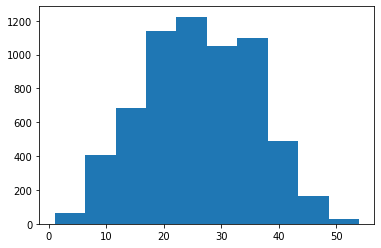

In [ ]:
rev_lengths = np.array([len(tweet) for tweet in mapped_tweet])
plt.hist(rev_lengths)
plt.show()

In [ ]:
# map words to integers with preprocessing using keras tokenizer
tokenizer = Tokenizer(num_words=vocab_size,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # filters out all punctuation
                      lower=True, # convert to lowercase
                      split=' ') # split on whitespaces

tokenizer.fit_on_texts(df['OriginalTweet'])
list_tokenized = tokenizer.texts_to_sequences(df['OriginalTweet'])

print( list_tokenized[:10] )

[[995, 483, 377, 2, 242, 35, 357, 468, 319, 484, 7, 535, 4, 1, 7, 35, 696, 97, 24, 79, 7, 1, 7, 72, 12, 10, 11], [162, 93, 22, 1, 25, 21, 17, 95, 22, 16, 1673, 8, 384, 79, 7, 35, 1, 315, 7, 5, 6, 7, 1, 378, 31, 18, 197, 263, 67, 22, 828, 3, 14, 5, 6], [17, 167, 67, 4, 67, 697, 55, 1, 190, 4, 385, 9, 57, 698, 32, 35, 1, 1674, 33, 1, 201, 120, 114, 338, 31, 118, 386, 8, 2, 90, 32, 784, 44, 42, 34, 277, 102, 78, 443, 149, 14, 1508], [48, 76, 829, 192, 431, 1675, 236, 24, 18, 277, 582, 7, 1, 1256, 536, 45, 8, 3, 5, 6], [57, 1159, 485, 75, 1160, 96, 4, 42, 1368, 29, 44, 2, 1, 931, 71, 5, 6, 16, 63, 12, 10, 11], [255, 8, 785, 8, 1257, 48, 100, 14, 144, 119, 5, 6, 12, 10, 11], [23, 22, 1068, 4, 398, 1676, 43, 243, 401, 2, 98, 1, 456, 7, 4, 444, 7, 130, 1369, 2, 413, 398, 50, 5, 6, 47, 107, 118, 28, 2, 830, 55, 1161, 15, 1370, 221, 932, 49, 62, 154], [158, 44, 42, 168, 1677, 9, 1, 1162, 786, 194, 500, 831, 4, 1509, 99, 98, 202, 1, 615, 3, 3, 14, 5, 996, 3, 12, 10, 11], [1, 272, 43, 27, 2, 933,

In [ ]:
# dictionary of words with indices
word_index = tokenizer.word_index
# convert all tweets to same length by padding with 0 or slicing
sequence_length = 35 # select 35 as max length based on distribution of mapped tweets
sequences = pad_sequences(list_tokenized, maxlen= sequence_length)
print(sequences)

[[   0    0    0 ...   12   10   11]
 [ 162   93   22 ...   14    5    6]
 [   1  190    4 ...  149   14 1508]
 ...
 [   0    0    0 ...   36    5    6]
 [   1   81    3 ...   12   10   11]
 [   0    0    0 ...   12   10   11]]


In [ ]:
# convert sentiment to real valued
le = LabelEncoder()
le.fit(df['Sentiment'])
df['target_encoded'] = le.transform(df['Sentiment'])
df_processed = pd.concat([df[['Sentiment', "target_encoded", "tweet_clean"]], pd.DataFrame(sequences)], axis=1)
df_processed.head()

,Sentiment,target_encoded,tweet_clean,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,34
0,Negative,0,breaking ontario s chief medical officer dr d...,0,0,0,0,0,0,0,...,97,24,79,7,1,7,72,12,10,11
1,Negative,0,well everyone at the grocery store i work at i...,162,93,22,1,25,21,17,...,18,197,263,67,22,828,3,14,5,6
2,Negative,0,i am more and more concerned about the elderly...,1,190,4,385,9,57,698,...,44,42,34,277,102,78,443,149,14,1508
3,Positive,1,supermarket was unusually busy last night mana...,0,0,0,0,0,0,0,...,582,7,1,1256,536,45,8,3,5,6
4,Negative,0,our latest report how department stores and sh...,0,0,0,0,0,0,0,...,1,931,71,5,6,16,63,12,10,11


In [ ]:
# save data
df_processed.to_csv("./data_deeplearning.csv", index = False, encoding = "utf-8")

In [ ]:
df = pd.read_csv("./data_deeplearning.csv")
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

5086 1272


In [ ]:
remove = ['Sentiment', "target_encoded", "tweet_clean"]

# split dataset
X_train = np.array(df.head(train_size).drop(remove, axis=1)) # replace with n_train
y_train = df.head(train_size).target_encoded.values

X_test = np.array(df.tail(test_size).drop(remove, axis=1)) # replace with n_test
y_test = df.tail(test_size).target_encoded.values

print('Training data X, y:', X_train.shape, y_train.shape)
print('Testing data X, y:', X_test.shape, y_test.shape)

Training data X, y: (5086, 35) (5086,)
Testing data X, y: (1272, 35) (1272,)


In [ ]:
# load embedding matrix
emb = loadtxt('./embedded_data.csv', delimiter=',')
emb

array([[-2.13883114,  0.0549665 , -1.46543276, ..., -1.89626944,
        -2.30746913,  0.97282922],
       [-0.76660615, -1.21993959, -2.24405622, ..., -1.29237962,
        -1.69344974,  0.97751206],
       [-1.43679869,  0.76140064, -3.09800816, ..., -1.44790125,
        -4.52036142,  1.80674946],
       ...,
       [ 0.44486162,  0.43326563, -1.66728425, ...,  0.69858426,
        -2.41147494,  1.95321858],
       [-1.0397501 ,  0.94362527, -1.61163914, ..., -0.33368155,
        -2.35109544,  2.11889815],
       [ 0.78431338,  0.2940124 , -0.54890811, ..., -0.44269753,
        -2.071172  ,  1.07922041]])

In [ ]:
# paramerers, based on results from preprocessing
emb_length = 300
max_length = 58 # length of longest sequence
sequence_length = 35

In [ ]:
# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 input_length = sequence_length))

model.add(layers.LSTM(sequence_length, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-2,
    patience=3,
    verbose=1,
    restore_best_weights=True)]
# train the model
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs=7,
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("LSTM_1")

Epoch 1/7
159/159 [==============================] - 16s 79ms/step - loss: 0.5904 - accuracy: 0.6736 - val_loss: 0.4873 - val_accuracy: 0.7712
Epoch 2/7
159/159 [==============================] - 14s 86ms/step - loss: 0.3323 - accuracy: 0.8702 - val_loss: 0.4087 - val_accuracy: 0.8286
Epoch 3/7
159/159 [==============================] - 12s 76ms/step - loss: 0.2141 - accuracy: 0.9221 - val_loss: 0.3702 - val_accuracy: 0.8640
Epoch 4/7
159/159 [==============================] - 12s 76ms/step - loss: 0.1545 - accuracy: 0.9514 - val_loss: 0.3663 - val_accuracy: 0.8923
Epoch 5/7
159/159 [==============================] - 14s 85ms/step - loss: 0.1116 - accuracy: 0.9695 - val_loss: 0.3700 - val_accuracy: 0.8852
Epoch 6/7
159/159 [==============================] - 12s 76ms/step - loss: 0.0965 - accuracy: 0.9750 - val_loss: 0.3968 - val_accuracy: 0.8994
Epoch 7/7
159/159 [==============================] - 12s 76ms/step - loss: 0.0736 - accuracy: 0.9805 - val_loss: 0.3833 - val_accuracy: 0.9088

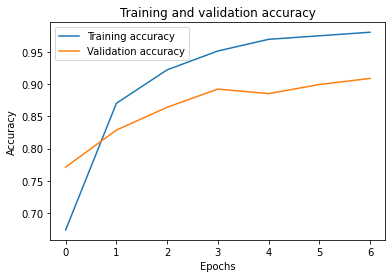

In [ ]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


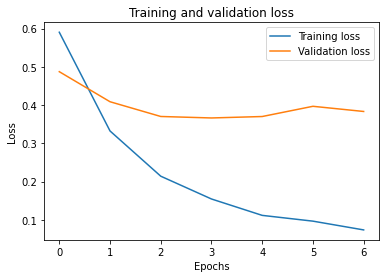

In [ ]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()# define model
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim = len(emb),
                 output_dim = emb_length,
                 weights=[emb],
                 input_length = sequence_length,
                 trainable = False))

model.add(layers.LSTM(sequence_length, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# define callbacks for early stopping during training
# stop training when the validation loss `val_accuracy` is no longer improving
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-3,
    patience=5,
    verbose=1,
    restore_best_weights=True)]
# train the model
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs=30,
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

model.save("LSTM_2")

Epoch 1/30
159/159 [==============================] - 11s 52ms/step - loss: 0.7119 - accuracy: 0.5029 - val_loss: 0.6920 - val_accuracy: 0.5165
Epoch 2/30
159/159 [==============================] - 8s 50ms/step - loss: 0.6942 - accuracy: 0.5035 - val_loss: 0.6917 - val_accuracy: 0.5189
Epoch 3/30
159/159 [==============================] - 8s 50ms/step - loss: 0.6931 - accuracy: 0.5179 - val_loss: 0.6921 - val_accuracy: 0.5142
Epoch 4/30
159/159 [==============================] - 8s 50ms/step - loss: 0.6912 - accuracy: 0.5112 - val_loss: 0.6915 - val_accuracy: 0.5031
Epoch 5/30
159/159 [==============================] - 8s 50ms/step - loss: 0.6908 - accuracy: 0.5279 - val_loss: 0.6904 - val_accuracy: 0.5157
Epoch 6/30
159/159 [==============================] - 8s 50ms/step - loss: 0.6891 - accuracy: 0.5303 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 7/30
159/159 [==============================] - 8s 50ms/step - loss: 0.6902 - accuracy: 0.5197 - val_loss: 0.6894 - val_accuracy: 0.522

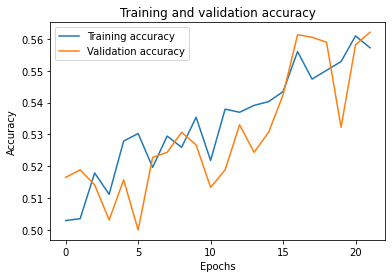

In [ ]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

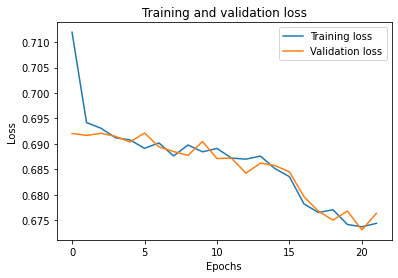

In [ ]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
df = pd.read_csv("./data_deeplearning.csv")
# define train and test size
train_size = int( len(df)*0.8 )
test_size = int( len(df) - train_size )
print(train_size, test_size)

5086 1272


In [ ]:
# split dataset
X_train = df.head(train_size).tweet_clean
y_train = df.head(train_size).target_encoded

X_test = df.tail(test_size).tweet_clean
y_test = df.tail(test_size).target_encoded

print('Training data X, y:', X_train.shape, y_train.shape)
print('Testing data X, y:', X_test.shape, y_test.shape)

Training data X, y: (5086,) (5086,)
Testing data X, y: (1272,) (1272,)


In [ ]:
# paramerers, based on results from preprocessing
emb_length = 300
max_length = 58 # length of longest sequence
sequence_length = 35

In [ ]:
# load pre-trained bert tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def inputs_bert(data, sequence_length):
    """ preprocess text for BERT model input """
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=sequence_length, #set max length of tokens equal to median tweet length
        pad_to_max_length=True,
        return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = inputs_bert(X_train, sequence_length)
test_input_ids, test_attention_masks = inputs_bert(X_test, sequence_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
print(train_input_ids.shape, test_input_ids.shape)

(5086, 35) (1272, 35)


In [ ]:
# add dense, dropout and output layer to pre-trained model and train only those
input_ids = tf.keras.Input(shape=(sequence_length,),dtype='int32')
attention_masks = tf.keras.Input(shape=(sequence_length,),dtype='int32')

output = bert_model([input_ids, attention_masks])
output = output[1]
output = tf.keras.layers.Dense(sequence_length, activation='relu')(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data = ([test_input_ids, test_attention_masks], y_test),
    epochs=5,
    batch_size=32)

Epoch 1/5
159/159 [==============================] - 1760s 11s/step - loss: 0.1342 - accuracy: 0.9707 - val_loss: 0.2379 - val_accuracy: 0.9371
Epoch 2/5
159/159 [==============================] - 1724s 11s/step - loss: 0.0969 - accuracy: 0.9770 - val_loss: 0.2163 - val_accuracy: 0.9450
Epoch 3/5
159/159 [==============================] - 1735s 11s/step - loss: 0.0558 - accuracy: 0.9898 - val_loss: 0.2734 - val_accuracy: 0.9324
Epoch 4/5
159/159 [==============================] - 1719s 11s/step - loss: 0.0427 - accuracy: 0.9927 - val_loss: 0.2359 - val_accuracy: 0.9450
Epoch 5/5
 23/159 [===>..........................] - ETA: 22:45 - loss: 0.0417 - accuracy: 0.9946

In [ ]:
# plot the development of the accuracy over epochs to see the training progress
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# plot the development of the loss over epochs to see the training progress
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()